# Knee Autocontour IPL to Python
### Created by Nathan Neeteson and Michelle Alejandra Espinosa Hernandez
#### Version 1 - June 10, 2022 - Translation of IPL code
#### Version 2 - July 22, 2022 - Completion of bone segmentation
#### Version 3 - November 14, 2022 - Implementation of ITSA
#### Version 4 - November 18, 2022 - Application of Laplace Hamming filter

This notebook tests / demonstrates the SimpleITK re-implementation of the IPL knee autocontour scripts
 
Notes: To plot sitk images, first sitk.GetArrayFromImage(image) then plt.imshow(array[indexes])

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import SimpleITK as sitk
import sys

from PIL import Image
from pylab import *
from scipy.fft import fft2, fftshift
from skimage import morphology
from skimage.filters import threshold_multiotsu, window
from skimage.measure import label
from tabulate import tabulate

from AutoContourKnee import AutocontourKnee

## Import image

In [2]:
# Create an autocontour object
autok = AutocontourKnee()

In [3]:
# Load the image
image_path = '/Users/michelleespinosa/Desktop/PhD/HRpQCT/Data/HR-test'
slice_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(image_path)
img = sitk.ReadImage(slice_filenames)

Text(0.5, 1.0, 'Initial slice')

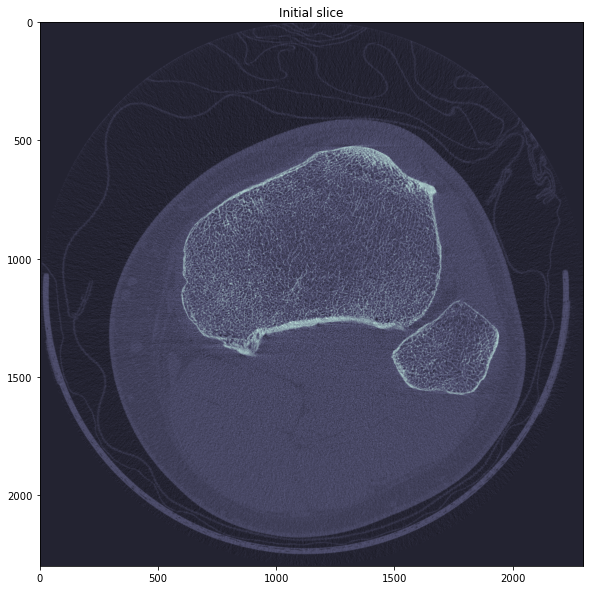

In [4]:
# Plot one slice of the image
image_array = sitk.GetArrayFromImage(img)

plt.figure(figsize=(10,10))
plt.imshow(image_array[3], cmap='bone')
plt.title('Initial slice')

In [5]:
# Extract a section of the image so everything runs faster
img_size = img.GetSize()
print(img_size)

(2300, 2300, 7)


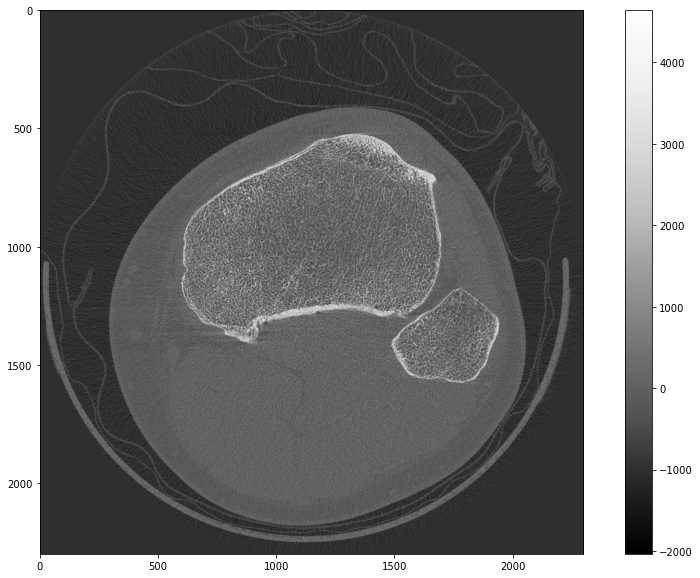

In [110]:
# Plot a slice of the section 
img_np = sitk.GetArrayFromImage(img)

slice_index = img_size[2]//3//2 # originally 168//3//2

plt.figure(figsize=(15,10))
plt.imshow(img_np[slice_index,:,:],cmap='Greys_r')
plt.colorbar()
plt.show()

## Periosteal mask

In [7]:
# Obtain periosteal mask
peri = autok.get_periosteal_mask(img)

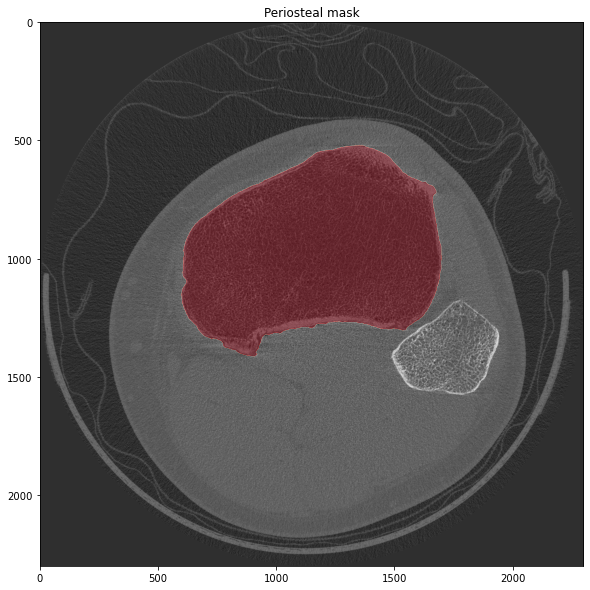

In [8]:
# Plot a slice of the image with the periosteal mask in red
peri_np = sitk.GetArrayFromImage(peri)>0

plt.figure(figsize=(15,10))
plt.imshow(img_np[slice_index],cmap='Greys_r')
plt.imshow(peri_np[slice_index],cmap='Reds',alpha=0.6*peri_np[slice_index])
plt.title('Periosteal mask')
plt.show()

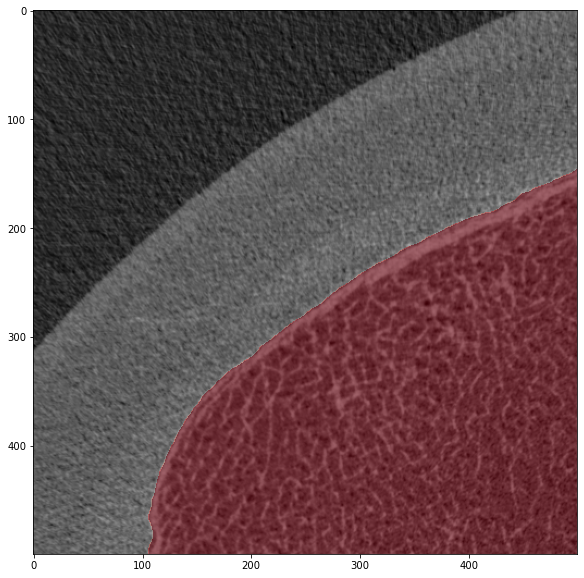

In [9]:
# Plot a slice of the image with the periosteal mask in red
peri_np = sitk.GetArrayFromImage(peri)>0

plt.figure(figsize=(15,10))
plt.imshow(img_np[slice_index,500:1000,500:1000],cmap='Greys_r')
plt.imshow(peri_np[slice_index,500:1000,500:1000],cmap='Reds',alpha=0.6*peri_np[slice_index,500:1000,500:1000])
plt.show()

## Endosteal mask

In [10]:
# Obtain endosteal mask (cortical and trabecular bone)
cort, trab = autok.get_endosteal_mask(img, peri)

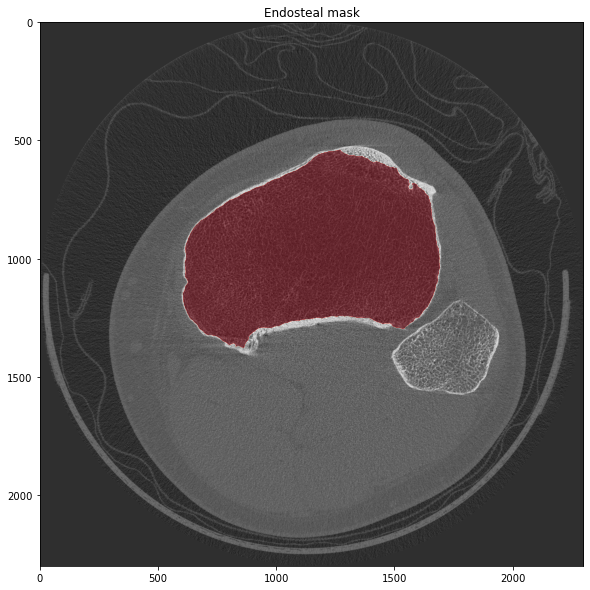

In [11]:
# Plot a slice of the image with the trabecular bone in red
trab_np = sitk.GetArrayFromImage(trab)>0

plt.figure(figsize=(15,10))
plt.imshow(img_np[slice_index],cmap='Greys_r')
plt.imshow(trab_np[slice_index],cmap='Reds',alpha=0.6*trab_np[slice_index])
plt.title('Endosteal mask')
plt.show()

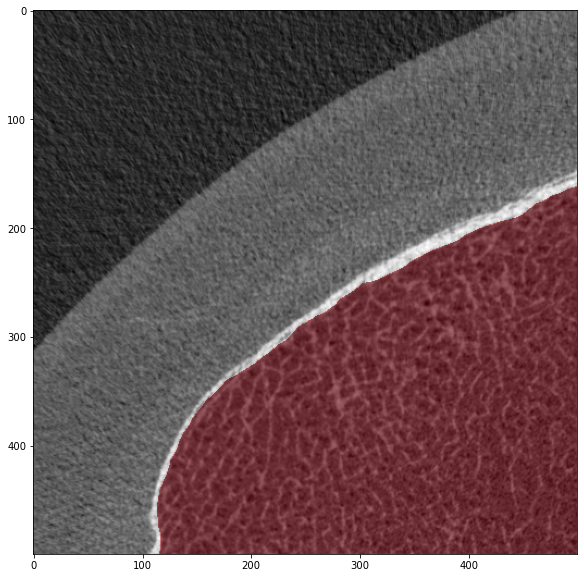

In [12]:
# Plot a slice of the image with the trabecular bone in red
trab_np = sitk.GetArrayFromImage(trab)>0

plt.figure(figsize=(15,10))
plt.imshow(img_np[slice_index,500:1000,500:1000],cmap='Greys_r')
plt.imshow(trab_np[slice_index,500:1000,500:1000],cmap='Reds',alpha=0.6*trab_np[slice_index,500:1000,500:1000])
plt.show()

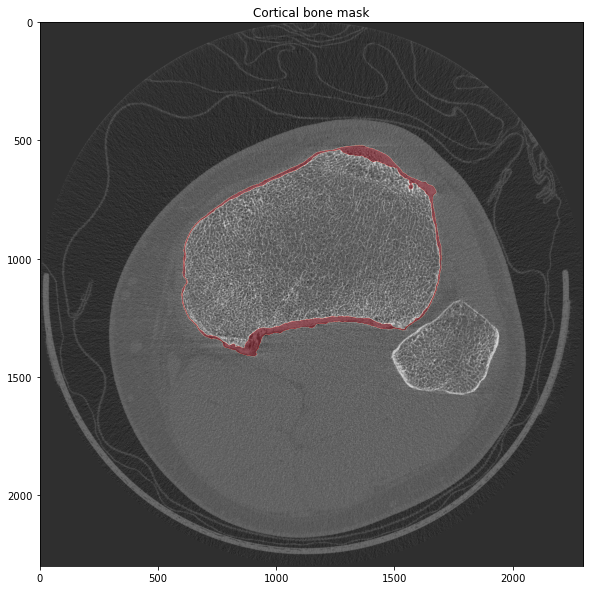

In [13]:
# Plot a slice of the image with the cortical bone in red
cort_np = sitk.GetArrayFromImage(cort)>0

plt.figure(figsize=(15,10))
plt.imshow(img_np[slice_index],cmap='Greys_r')
plt.imshow(cort_np[slice_index],cmap='Reds',alpha=0.6*cort_np[slice_index])
plt.title('Cortical bone mask')
plt.show()

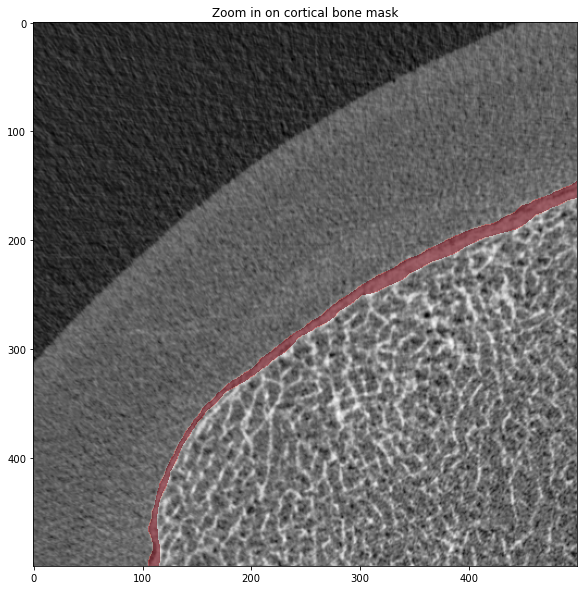

In [14]:
# Plot a slice of the image with the cortical bone in red
cort_np = sitk.GetArrayFromImage(cort)>0

plt.figure(figsize=(15,10))
plt.imshow(img_np[slice_index,500:1000,500:1000],cmap='Greys_r')
plt.imshow(cort_np[slice_index,500:1000,500:1000],cmap='Reds',alpha=0.6*cort_np[slice_index,500:1000,500:1000])
plt.title('Zoom in on cortical bone mask')
plt.show()

## Laplace Hamming Filter

In [186]:
image = img_np*peri_np

ham = window('hamming', image.shape)
f = fftn(image)
f_complex = fftshift(f) # a+bj
f_filtered = ham * f_complex

f_filtered_shifted = fftshift(f_filtered)
inv_img = ifftn(f_filtered_shifted)

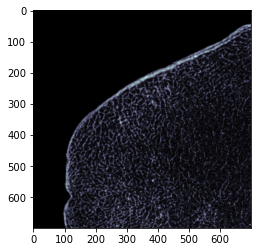

In [187]:
plt.imshow(abs(inv_img[0,500:1200,500:1200]),cmap='bone')

In [192]:
log = sitk.LaplacianRecursiveGaussianImageFilter()
filtered_image = sitk.GetArrayFromImage(log.Execute(sitk.Cast(sitk.GetImageFromArray(inv_img),sitk.sitkUInt64)))

RuntimeError: Exception thrown in SimpleITK Cast: ../Code/BasicFilters/src/sitkCastImageFilter.cxx:95:
sitk::ERROR: Filter does not support casting from casting complex of 64-bit float to 64-bit unsigned integer

In [163]:
image = img_np

wimage = image * window('hamming', image.shape)  # window image to improve FFT
#filtered_image = difference_of_gaussians(image, 1, 12)
log = sitk.LaplacianRecursiveGaussianImageFilter()
filtered_image = sitk.GetArrayFromImage(log.Execute(sitk.GetImageFromArray(wimage)))

filtered_wimage = filtered_image * window('hamming', image.shape)
im_f_mag = fftshift(np.abs(fftn(wimage)))
fim_f_mag = fftshift(np.abs(fftn(filtered_wimage)))

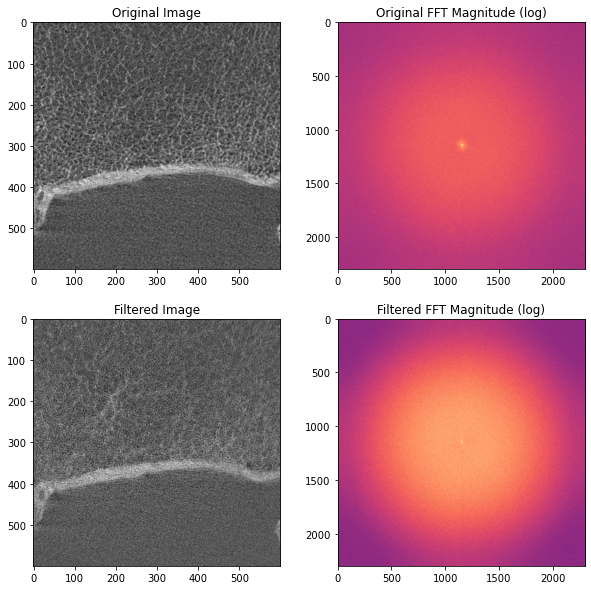

In [164]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax[0, 0].imshow(image[6,900:1500,900:1500], cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 1].imshow(np.log(im_f_mag[6]), cmap='magma')
ax[0, 1].set_title('Original FFT Magnitude (log)')
ax[1, 0].imshow(filtered_image[6,900:1500,900:1500], cmap='gray')
ax[1, 0].set_title('Filtered Image')
ax[1, 1].imshow(np.log(fim_f_mag[6]), cmap='magma')
ax[1, 1].set_title('Filtered FFT Magnitude (log)')
plt.show()

------testing------

In [117]:
hw = window('hamming', img_np.shape)
wimage = img_np * hw

image_f = np.abs(fftshift(fft2(img_np)))
wimage_f = np.abs(fftshift(fft2(wimage)))

In [121]:
log = sitk.LaplacianRecursiveGaussianImageFilter()
Lfilt_ski = log.Execute(sitk.GetImageFromArray(wimage_f))

In [138]:
filt_i = scipy.fft.ifft(Lfilt_ski)

KeyboardInterrupt: 

In [ ]:
plt.imshow(filt_i[0])

In [120]:


img_i = np.abs(fftshift())

#img_np_filt = wimage+sitk.GetArrayFromImage(Lfilt_ski)

fig, ax = plt.subplots (1, 2, figsize=(10,5))
ax[0].set_title('Laplace-Hamming')
#ax[0].imshow(img_np_filt[6], cmap='bone')
ax[0].imshow(img_i[6], cmap='bone')
#ax[1].hist(img_np_filt.ravel())
ax[1].hist(img_i.ravel())
plt.show()

ValueError: axes exceeds dimensionality of input

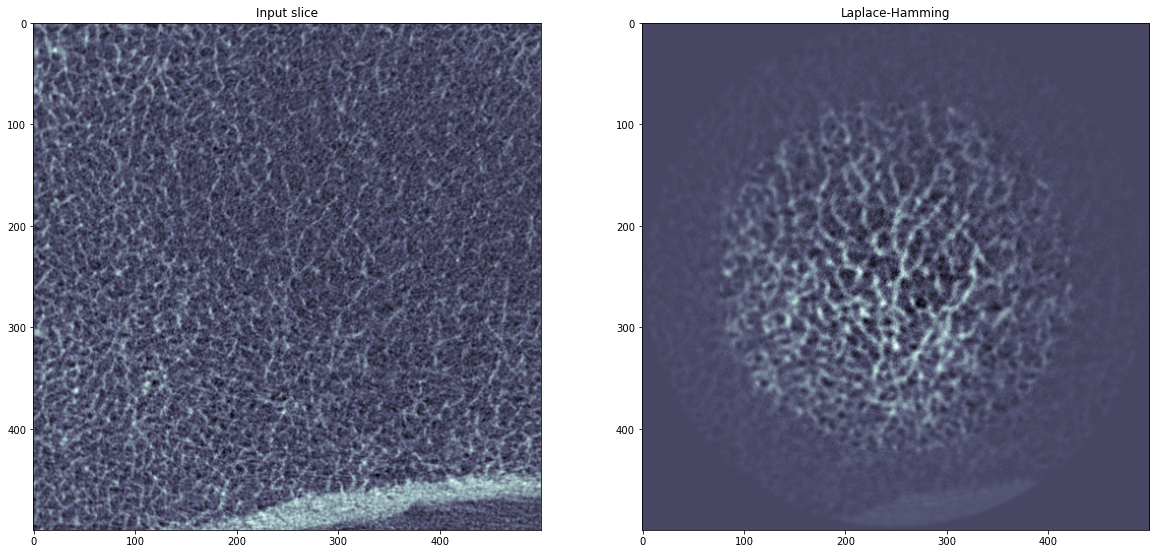

In [107]:
fig, ax = plt.subplots (1, 2, figsize=(20,10))
ax[0].set_title('Input slice')
ax[0].imshow(img_np[6], cmap='bone')
ax[1].set_title('Laplace-Hamming')
ax[1].imshow(img_np_filt[6],cmap='bone')
plt.show()

## ROI masks

In [19]:
# Apply masks to input image
trab_ROI = trab_np * img_np_filt
cort_ROI = cort_np * img_np_filt
peri_ROI = peri_np * img_np_filt

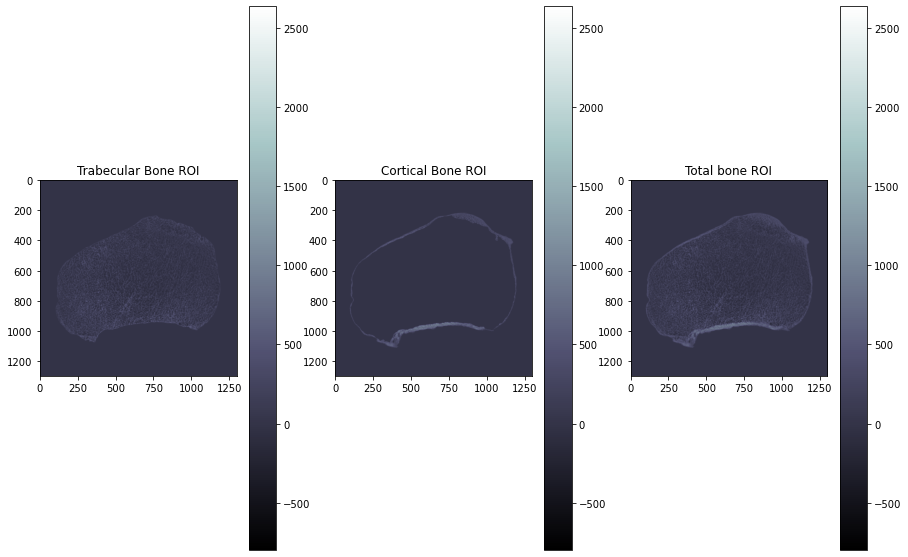

In [20]:
# Plot ROI
_min, _max = np.amin([trab_ROI,cort_ROI]), np.amax([trab_ROI,cort_ROI]) # Get min and max pixel values to plot on same scale

fig, ax = plt.subplots (1, 3, figsize=(15,10))
im = ax[0].imshow(trab_ROI[slice_index,300:1600,500:1800], cmap='bone', vmin = _min, vmax = _max)
ax[0].set_title('Trabecular Bone ROI')
ax[0].autoscale(False)
plt.colorbar(im, ax = ax[0])

im = ax[1].imshow(cort_ROI[slice_index,300:1600,500:1800], cmap='bone', vmin = _min, vmax = _max)
ax[1].set_title('Cortical Bone ROI')
ax[1].autoscale(False)
plt.colorbar(im, ax = ax[1])

im = ax[2].imshow(peri_ROI[slice_index,300:1600,500:1800], cmap='bone', vmin = _min, vmax = _max)
ax[2].set_title('Total bone ROI')
ax[2].autoscale(False)
plt.colorbar(im, ax = ax[2])

# ITSA

In [21]:
# Due to the calculations in ITSA, the minimum intensity must be 0, 
# hence the minimum intensity value will be added to all pixels
ROI_adj = trab_ROI - np.nanmin(trab_ROI)

# Delete background (highest peak in histogram)
vals, cts = np.unique(ROI_adj, return_counts=True)
maxval = vals[np.argmax(cts)]
ROI_nb = np.where(ROI_adj!=maxval, ROI_adj, np.nan)

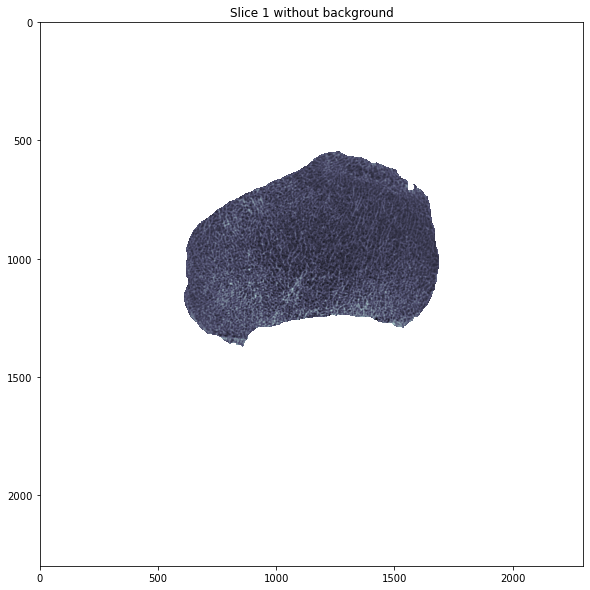

In [22]:
# Plot slice without background
plt.figure(figsize=(15,10))
plt.imshow(ROI_nb[slice_index], cmap='bone')
plt.title('Slice %i without background' %slice_index);

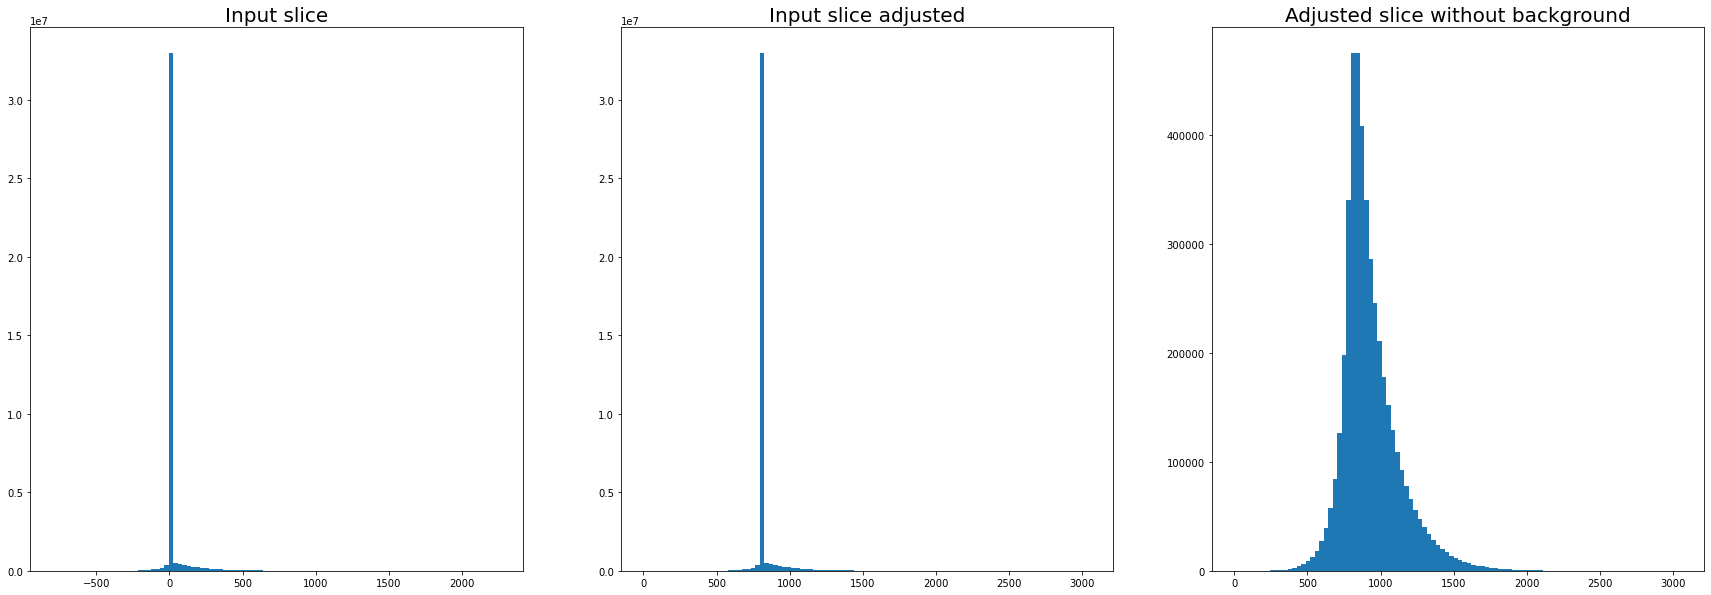

In [23]:
# Compare histograms
fig, ax = plt.subplots (1, 3, figsize=(30,10))
ax[0].hist(trab_ROI.ravel(), bins=100);
ax[0].set_title('Input slice').set_fontsize(20);
ax[1].hist(ROI_adj.ravel(), bins=100);
ax[1].set_title('Input slice adjusted').set_fontsize(20);
ax[2].hist(ROI_nb.ravel(), bins=100);
ax[2].set_title('Adjusted slice without background').set_fontsize(20);

## Initial Otsu threshold values

In [24]:
ROI_nmask = np.ma.masked_invalid(ROI_nb)
thresholds = threshold_multiotsu(ROI_nmask.compressed(), classes=4)
print(thresholds)

th1 = thresholds[1]
print(th1)

th_img = label(ROI_nmask > th1).astype(bool)

[ 830.36534856 1009.58089141 1284.37805712]
1009.5808914131064


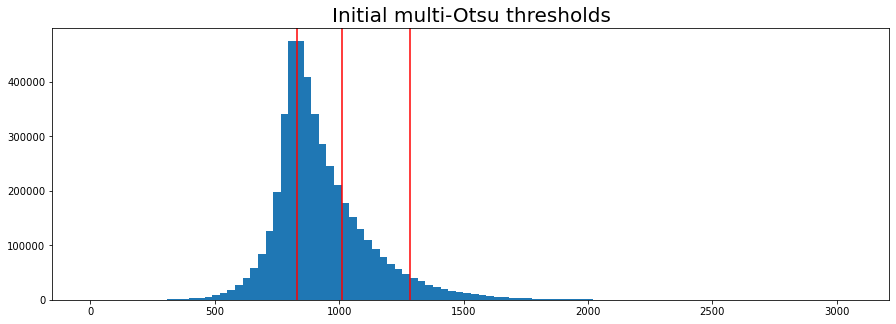

In [25]:
# Histogram
plt.figure (figsize=(15,5))
plt.hist(ROI_nb.ravel(), bins=100)
for t in range(len(thresholds)):
    plt.axvline(thresholds[t], color='r')
plt.title('Initial multi-Otsu thresholds').set_fontsize(20);

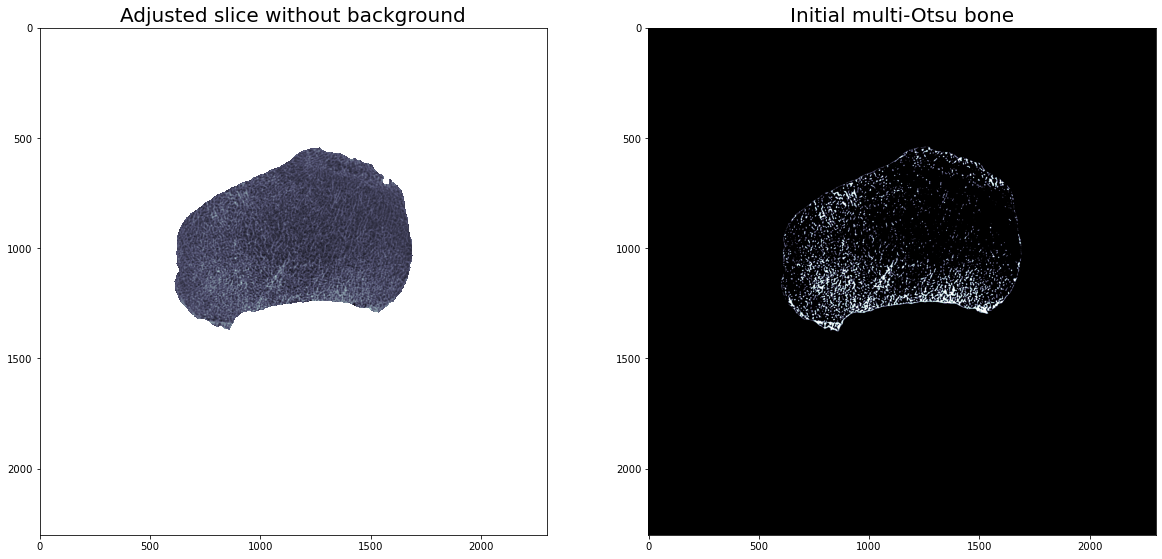

In [26]:
# Plot resulting image
fig, ax = plt.subplots (1, 2, figsize=(20,10))
ax[0].imshow(ROI_nb[slice_index], 'bone')
ax[0].set_title('Adjusted slice without background').set_fontsize(20);
ax[1].imshow(th_img[slice_index], 'bone')
ax[1].set_title('Initial multi-Otsu bone').set_fontsize(20);

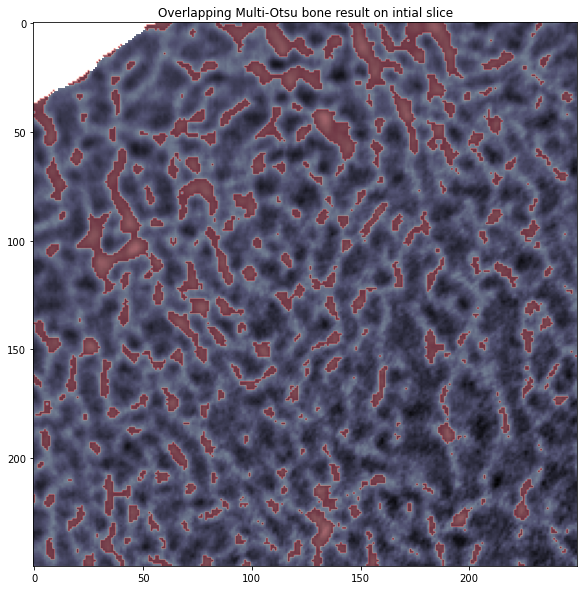

In [27]:
# Overlapping multi-Otsu result to image
plt.figure(figsize=(15,10))
plt.imshow(ROI_nb[slice_index,750:1000,750:1000], cmap='bone')
plt.imshow(th_img[slice_index,750:1000,750:1000], cmap='Reds', alpha=0.6*th_img[slice_index,750:1000,750:1000])
plt.title('Overlapping Multi-Otsu bone result on intial slice')
plt.show()

### ITSA threshold

In [28]:
def optimize_thresh(roi, threshold, view_plots):
    # Optimize threshold to separate marrow and bone
    k = 1
    
    ThPrev = 0 #previous
    ThRev = threshold #revised

    roi_im = sitk.GetImageFromArray(roi) ## change array into sitk image

    while ThRev!=ThPrev: #while new threshold is NOT equal to prev threshold
        
        ThPrev = ThRev #update the previous threshold for comparison in subsequent iterations
        
        kneetrb0 = label(roi > ThRev).astype(bool)
        
        kneetrbmask_rso = (morphology.remove_small_objects(kneetrb0, min_size=5, connectivity=1)).astype(int) 
        
        kneetrbmask_n = cv2.normalize(src=kneetrbmask_rso, dst=None, alpha=0.0, beta=255.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
        kneetrbmask_ni = sitk.GetImageFromArray(kneetrbmask_n) ## change array into image
        kneetrbmask_not = sitk.BinaryThreshold(kneetrbmask_ni, 0, 1) ## separate bone/background, background=1, bone=0
        kneetrbmask = sitk.Not(kneetrbmask_not)  
        kneetrbseg1 = sitk.Mask(roi_im, kneetrbmask) ## mask 
        
        #premarrow = roi - kneetrbseg1  #original ROI - bone = marrow
        roi_im64 = sitk.Cast(roi_im,sitk.sitkUInt64) ## Convert images from 64 bit floats to 64 bit ints
        kneetrbseg164 = sitk.Cast(kneetrbseg1,sitk.sitkUInt64) 
        premarrow = roi_im64 - kneetrbseg164

        premarrow0 = sitk.GetArrayFromImage(premarrow) ## Convert images to numpy arrays for masking
        kneetrbseg0 = sitk.GetArrayFromImage(kneetrbseg164)

        # Mask the 0's in the image to exclude in the mean calculations
        marrowsegp = np.ma.masked_where(premarrow0 == 0, premarrow0)
        bonesegp = np.ma.masked_where(kneetrbseg0 == 0, kneetrbseg0) 

        # Calculate mean signal intensities of marrow and bone
        marrowsegI = np.mean(marrowsegp)
        bonesegI = np.mean(bonesegp)

        # Threshold optimization equation
        ThRev = (1+((bonesegI-marrowsegI)/bonesegI))*marrowsegI 
        
        fig, axs = plt.subplots (1,2, figsize=(20,10))  
        axs[0].imshow(premarrow0[slice_index], cmap='bone') 
        axs[0].set_title('Marrow')
        axs[1].imshow(kneetrbseg0[slice_index], cmap='bone') 
        axs[1].set_title('Bone')
        plt.show()

        print(f"Revised Threshold={ThRev}\n\tMean marrow intensity={marrowsegI} pixels\n\tMean bone intensity={bonesegI} pixels\n\n")
        
        k+=1
        if k==50:
            break
        
    return ThRev, kneetrbseg1

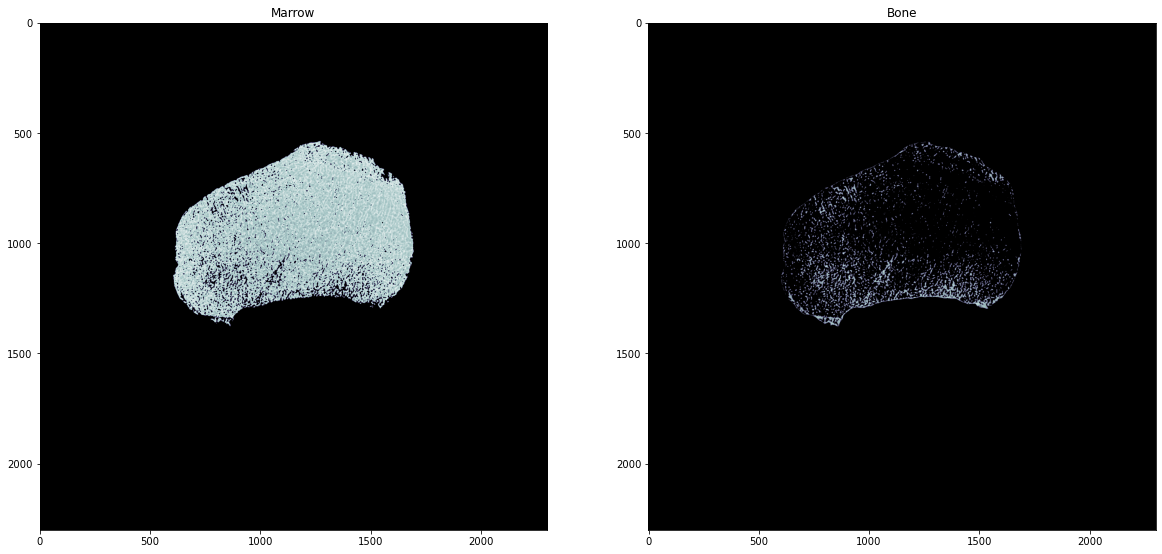

Revised Threshold=1085.6685874963166
	Mean marrow intensity=839.9461450045096 pixels
	Mean bone intensity=1187.2793419795557 pixels




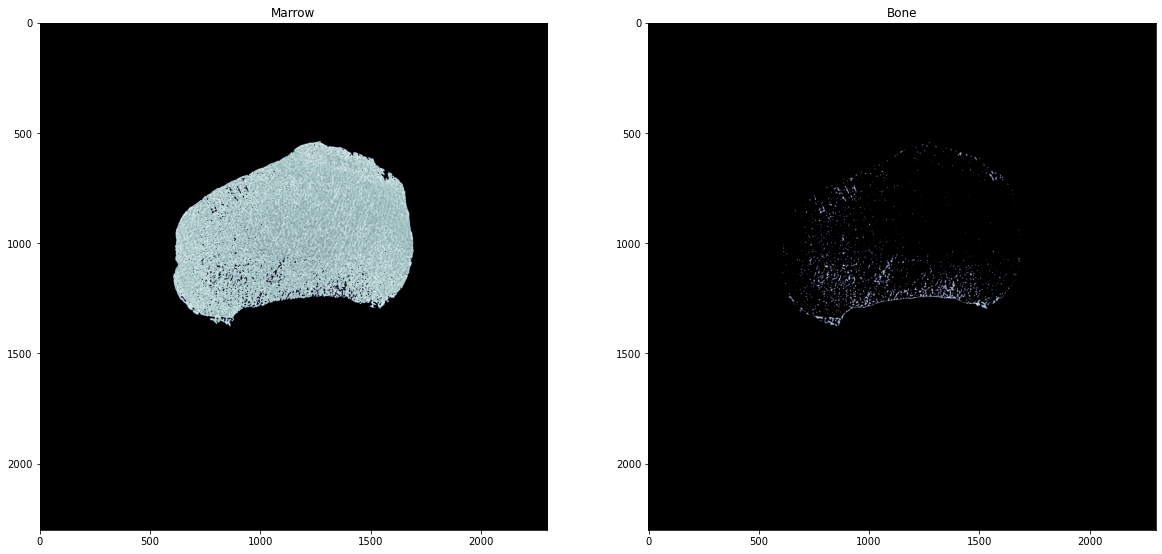

Revised Threshold=1134.6256660427914
	Mean marrow intensity=861.4961895828671 pixels
	Mean bone intensity=1261.4168478812585 pixels




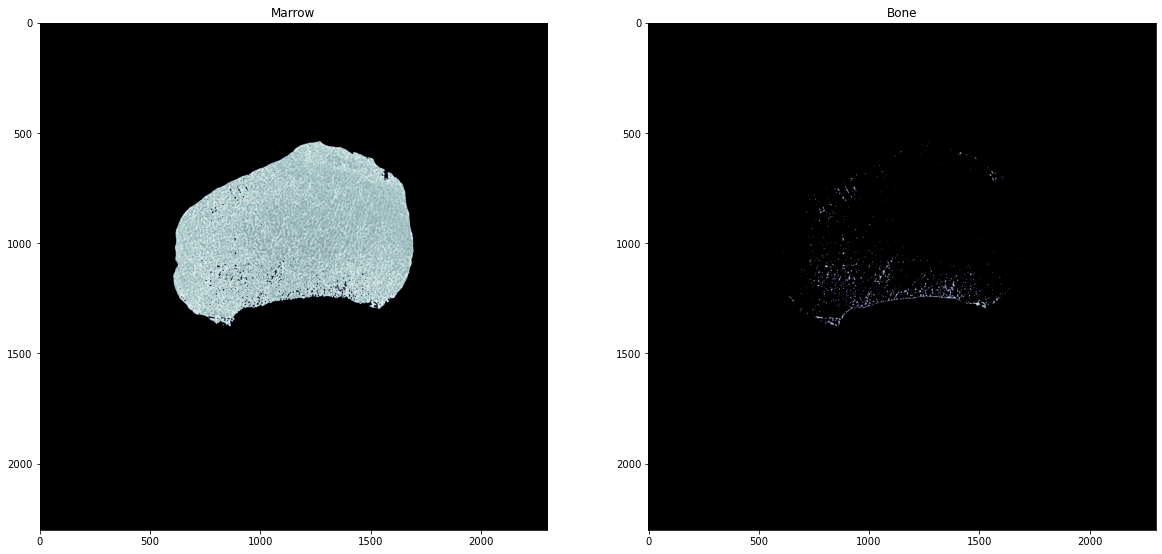

Revised Threshold=1163.7437553122822
	Mean marrow intensity=872.856785421773 pixels
	Mean bone intensity=1309.1382878016336 pixels




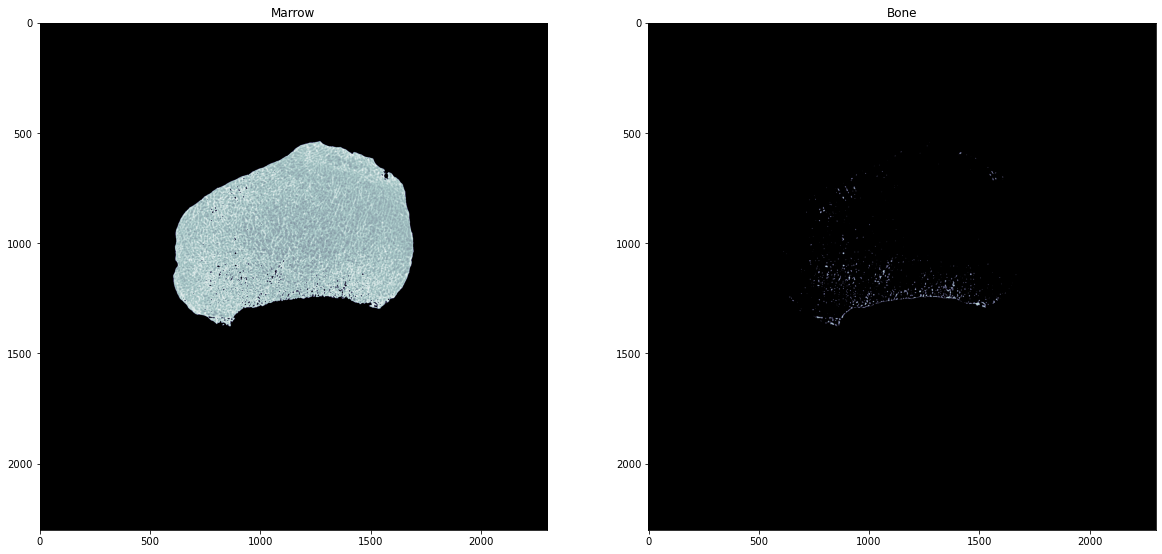

Revised Threshold=1180.2999957710754
	Mean marrow intensity=878.8421014534107 pixels
	Mean bone intensity=1337.6940860896468 pixels




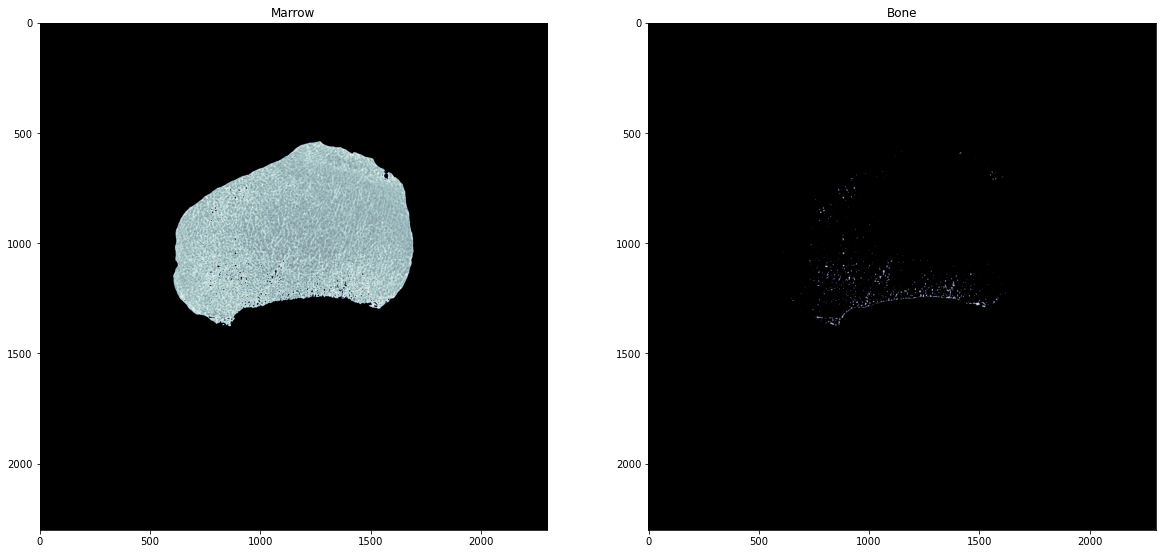

Revised Threshold=1189.3586484192565
	Mean marrow intensity=881.9712077417494 pixels
	Mean bone intensity=1353.8029716012995 pixels




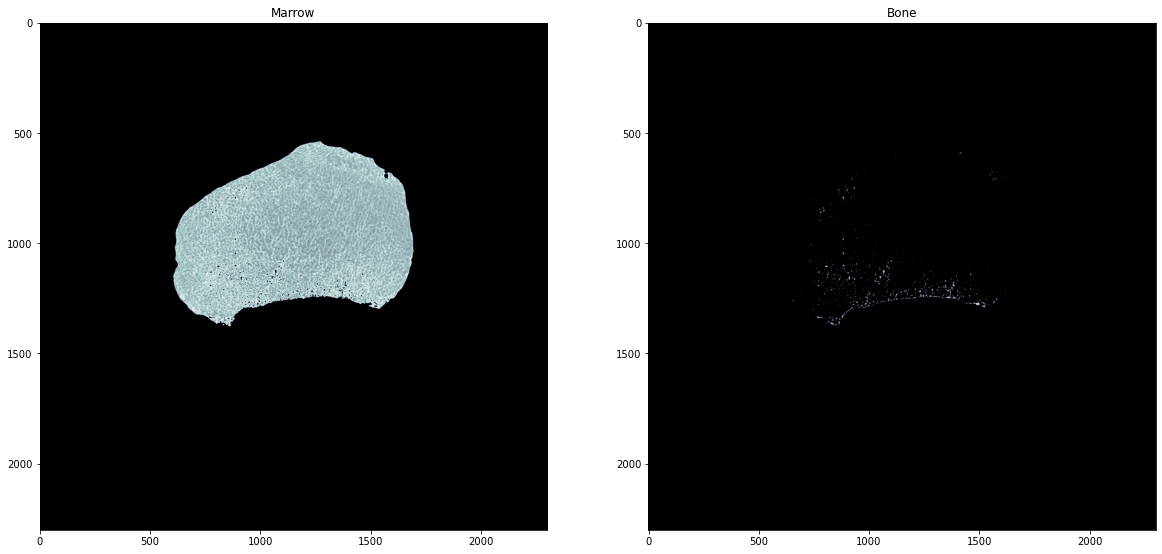

Revised Threshold=1194.2403214102994
	Mean marrow intensity=883.6144037148918 pixels
	Mean bone intensity=1362.6354342238456 pixels




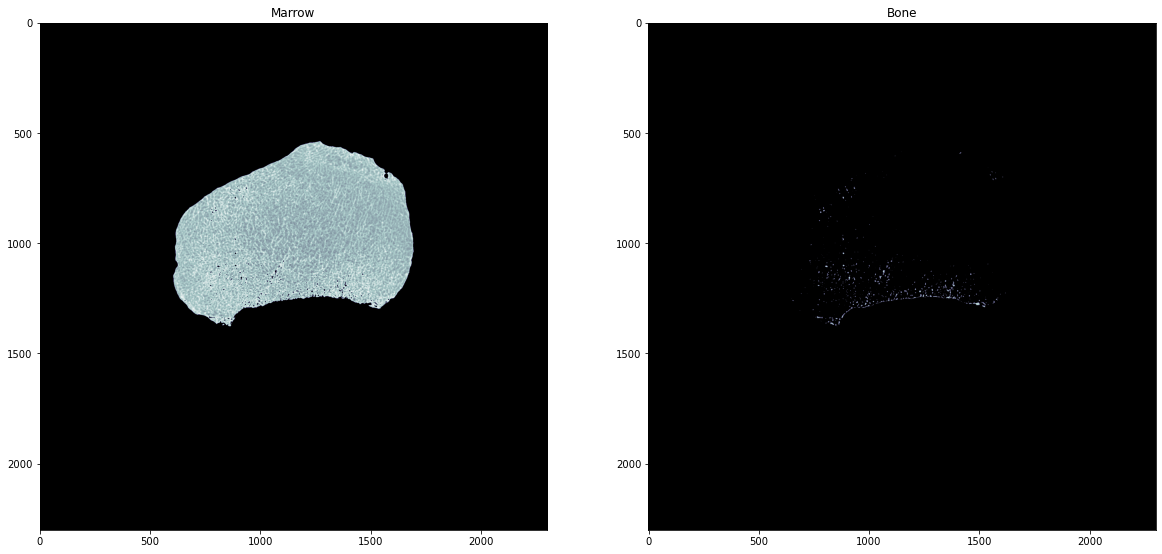

Revised Threshold=1196.8370549295444
	Mean marrow intensity=884.4746092277315 pixels
	Mean bone intensity=1367.381056097941 pixels




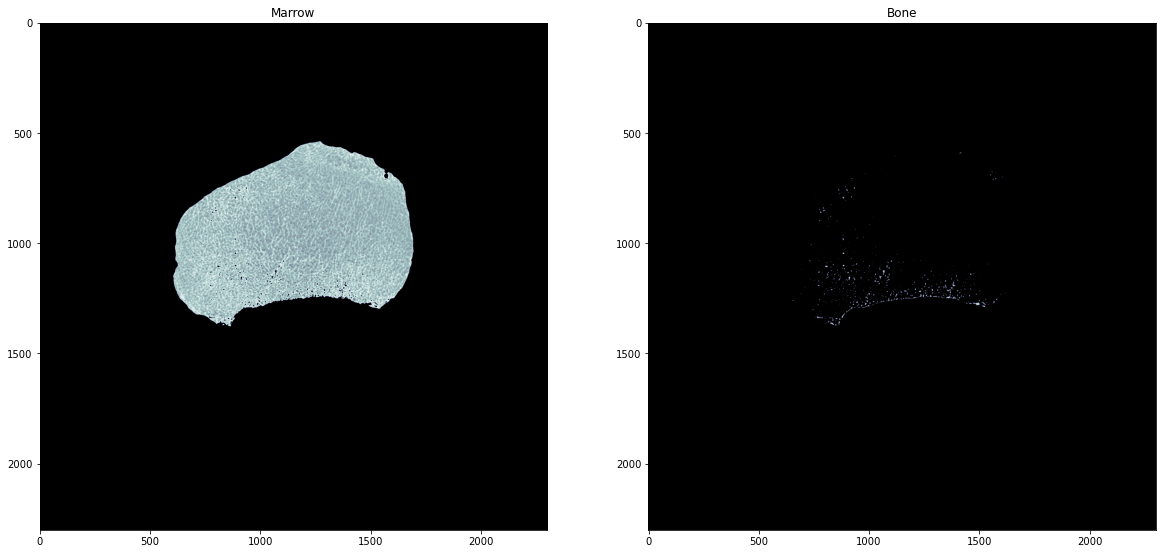

Revised Threshold=1198.2013943725822
	Mean marrow intensity=884.9225881190852 pixels
	Mean bone intensity=1369.8880523247062 pixels




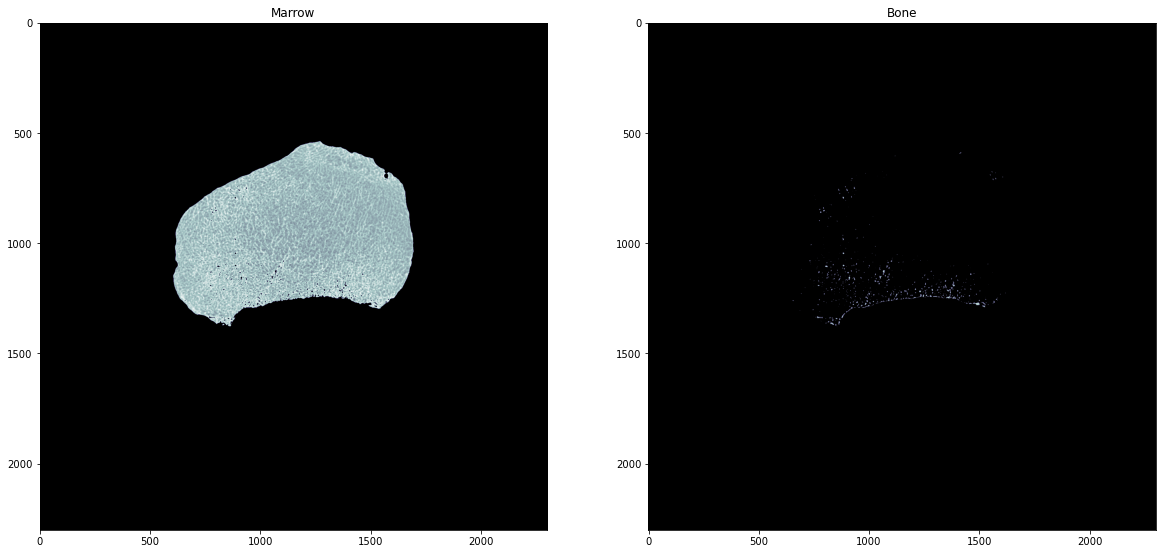

Revised Threshold=1198.9204976966496
	Mean marrow intensity=885.1577636791397 pixels
	Mean bone intensity=1371.2129541368838 pixels




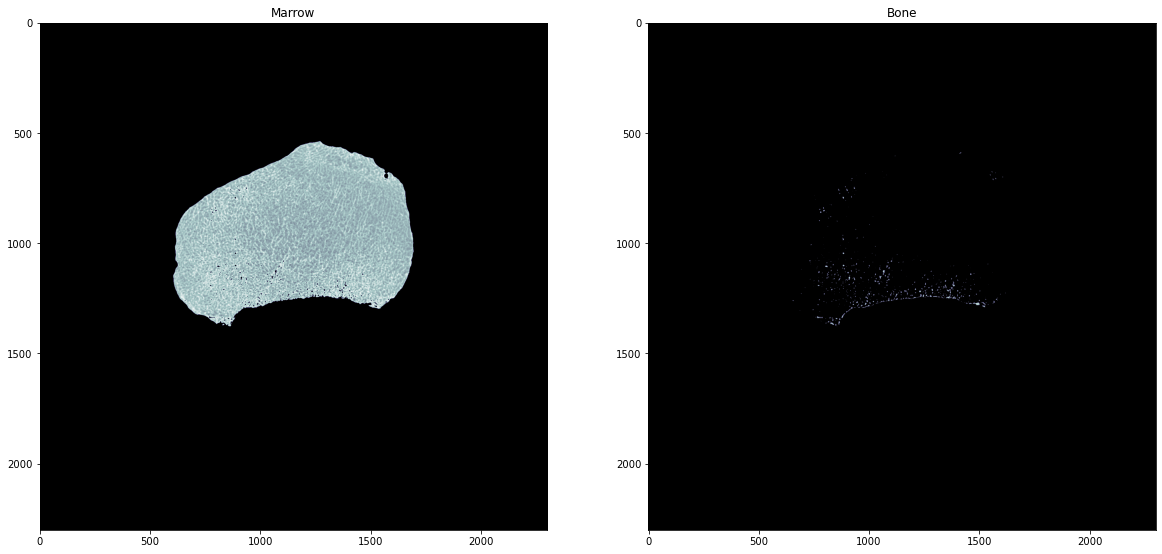

Revised Threshold=1199.2930772704538
	Mean marrow intensity=885.2787150781517 pixels
	Mean bone intensity=1371.9014663024604 pixels




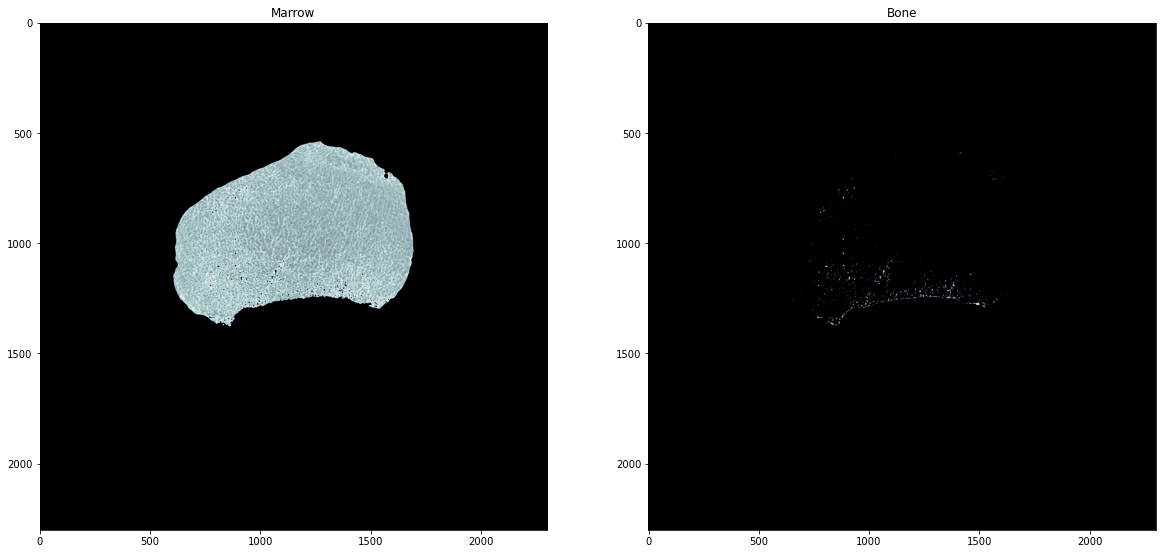

Revised Threshold=1199.5040397077464
	Mean marrow intensity=885.3480315227155 pixels
	Mean bone intensity=1372.2900616519046 pixels




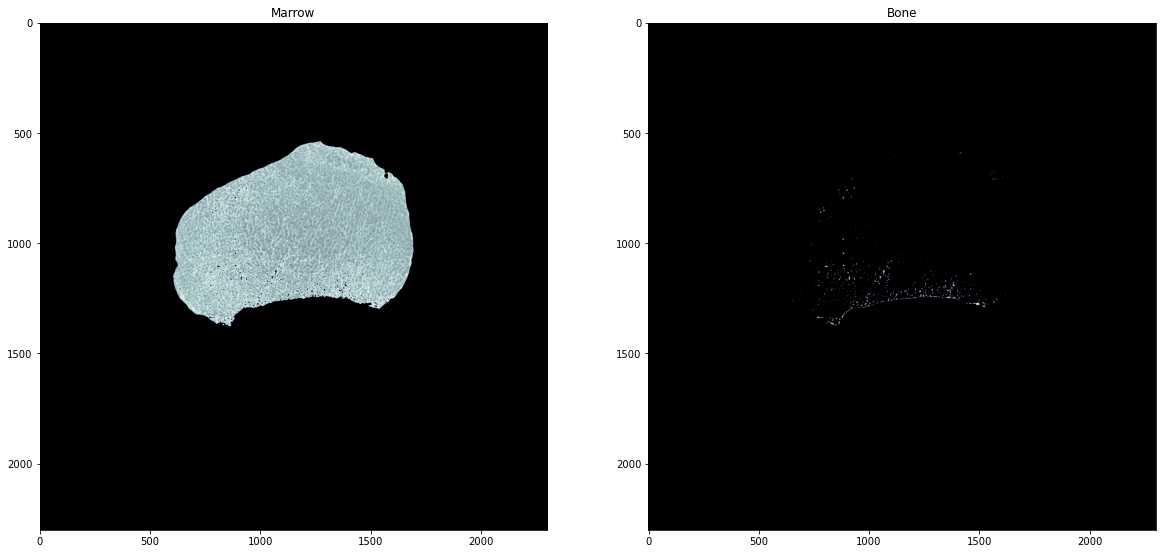

Revised Threshold=1199.6190491738753
	Mean marrow intensity=885.3858450397274 pixels
	Mean bone intensity=1372.5019170948815 pixels




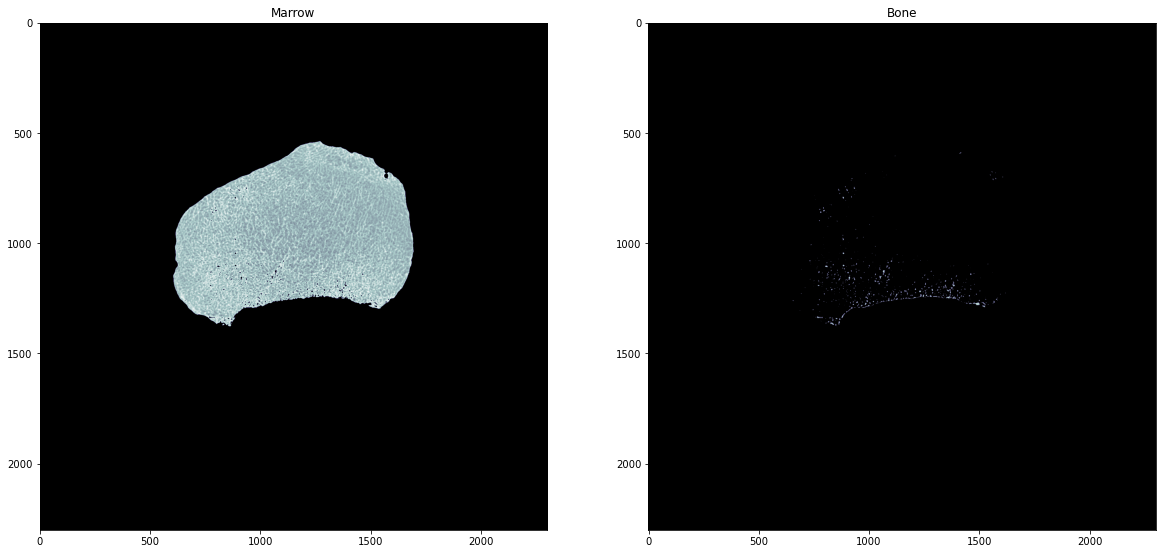

Revised Threshold=1199.680428800399
	Mean marrow intensity=885.4056824365207 pixels
	Mean bone intensity=1372.6155824820719 pixels




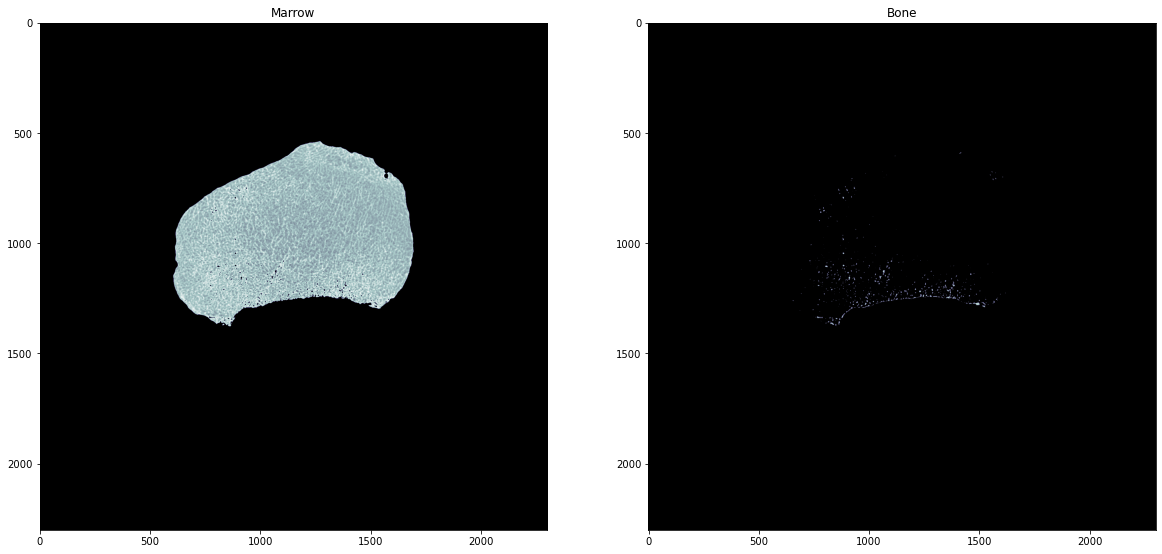

Revised Threshold=1199.713181320064
	Mean marrow intensity=885.416309963171 pixels
	Mean bone intensity=1372.6761671112563 pixels




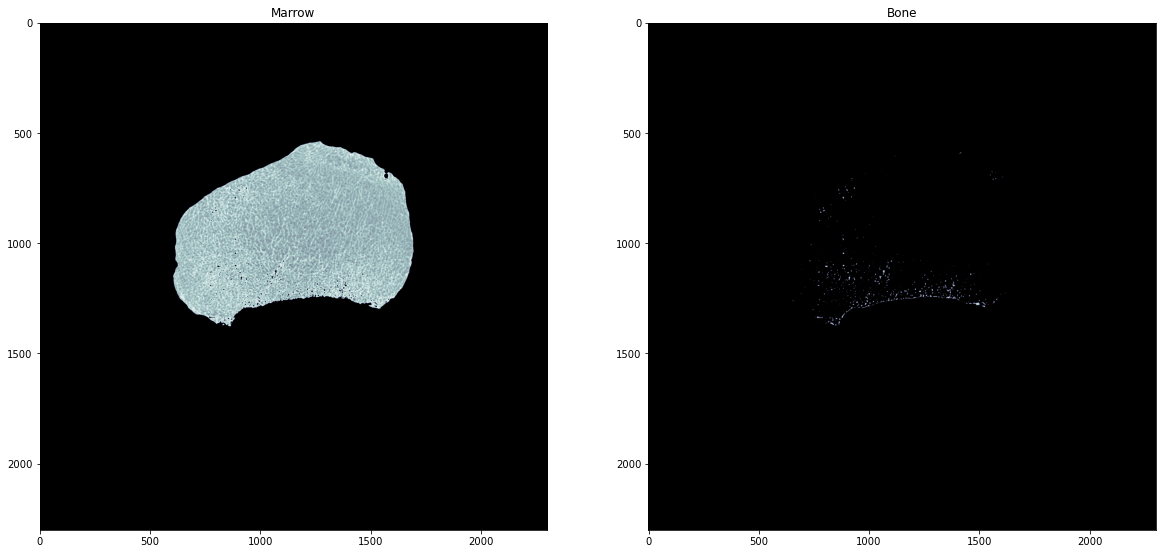

Revised Threshold=1199.7297818421841
	Mean marrow intensity=885.4219154426801 pixels
	Mean bone intensity=1372.7065017217192 pixels




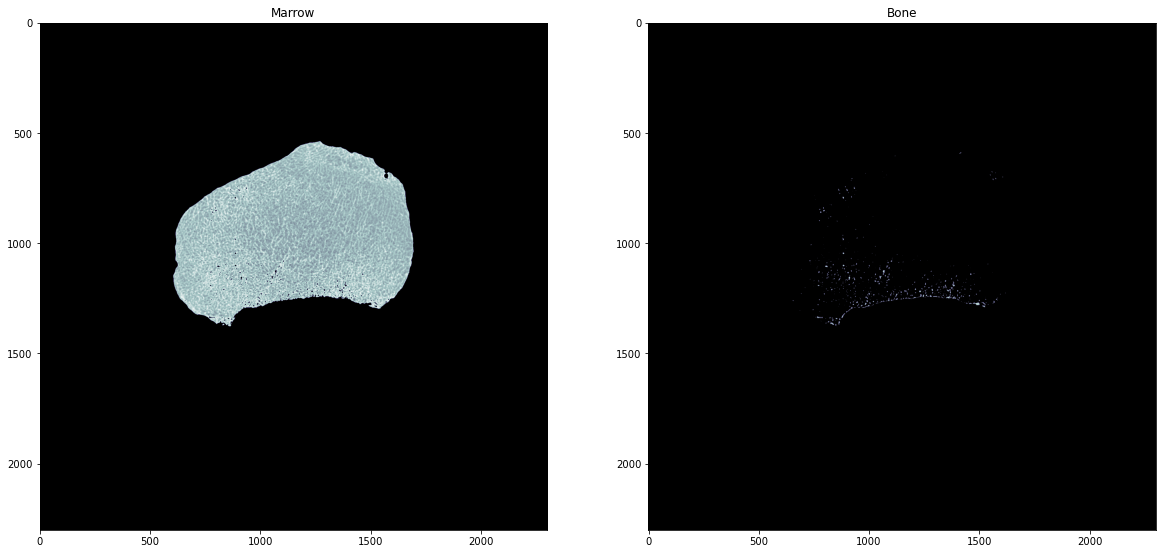

Revised Threshold=1199.7364504790717
	Mean marrow intensity=885.4240377698537 pixels
	Mean bone intensity=1372.7189086326787 pixels




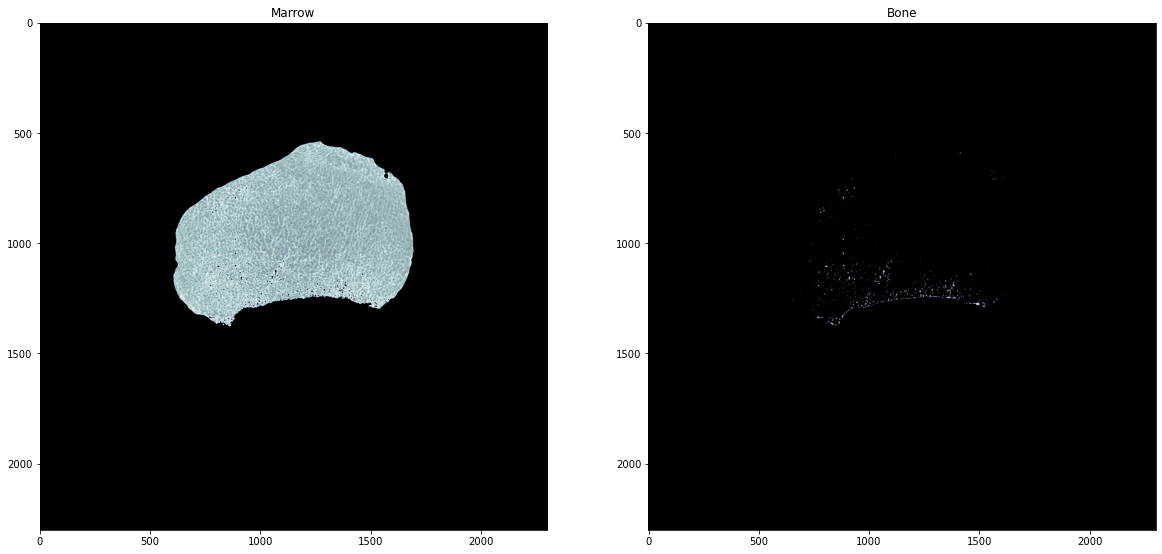

Revised Threshold=1199.7404996195537
	Mean marrow intensity=885.4253263116218 pixels
	Mean bone intensity=1372.726442264767 pixels




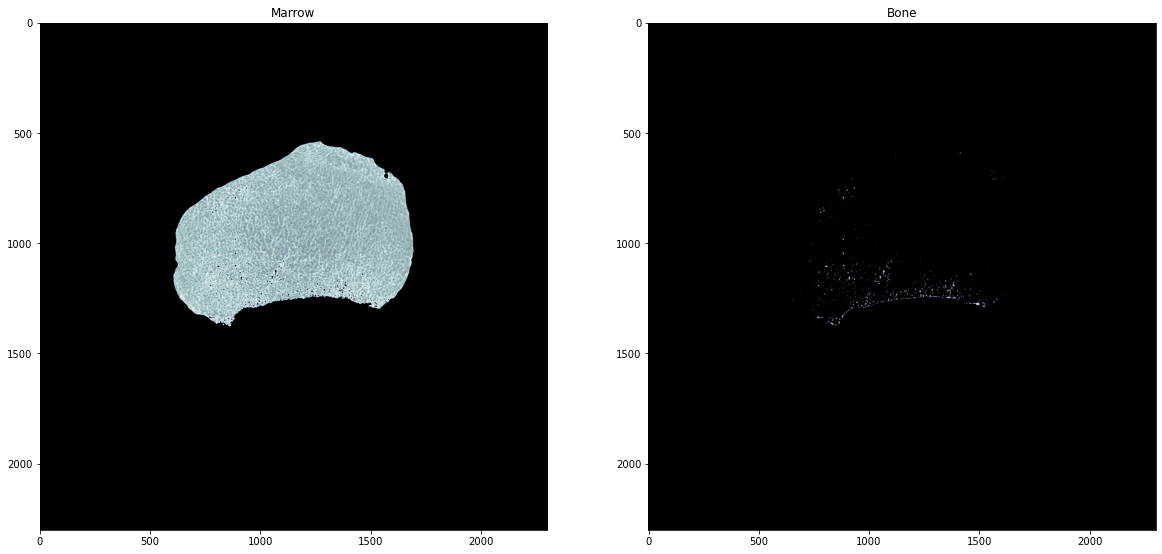

Revised Threshold=1199.7421669841247
	Mean marrow intensity=885.425856884566 pixels
	Mean bone intensity=1372.7295445384925 pixels




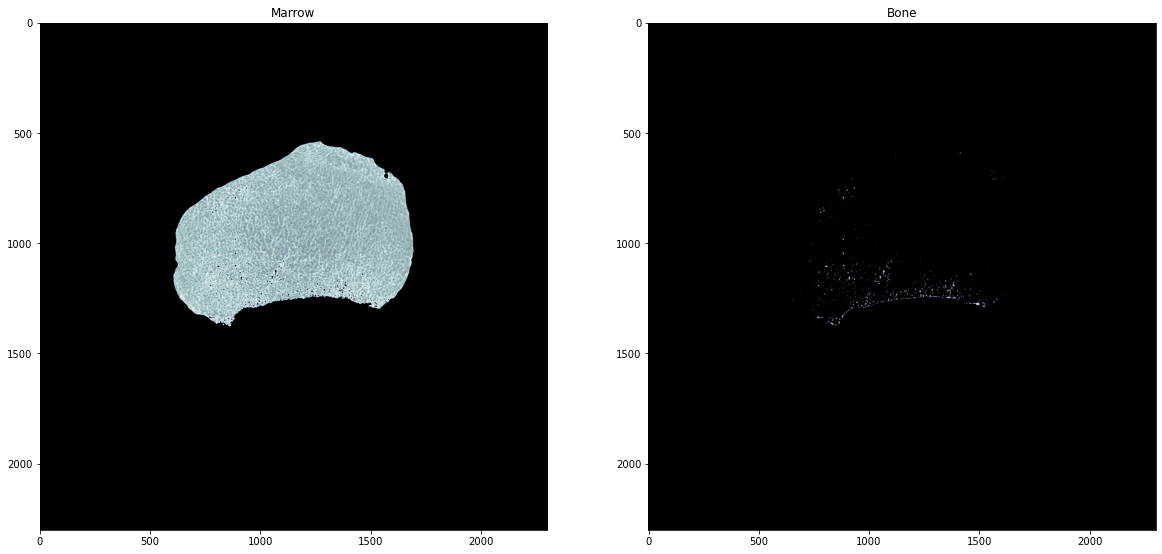

Revised Threshold=1199.7424051824648
	Mean marrow intensity=885.4259326805542 pixels
	Mean bone intensity=1372.729987729498 pixels




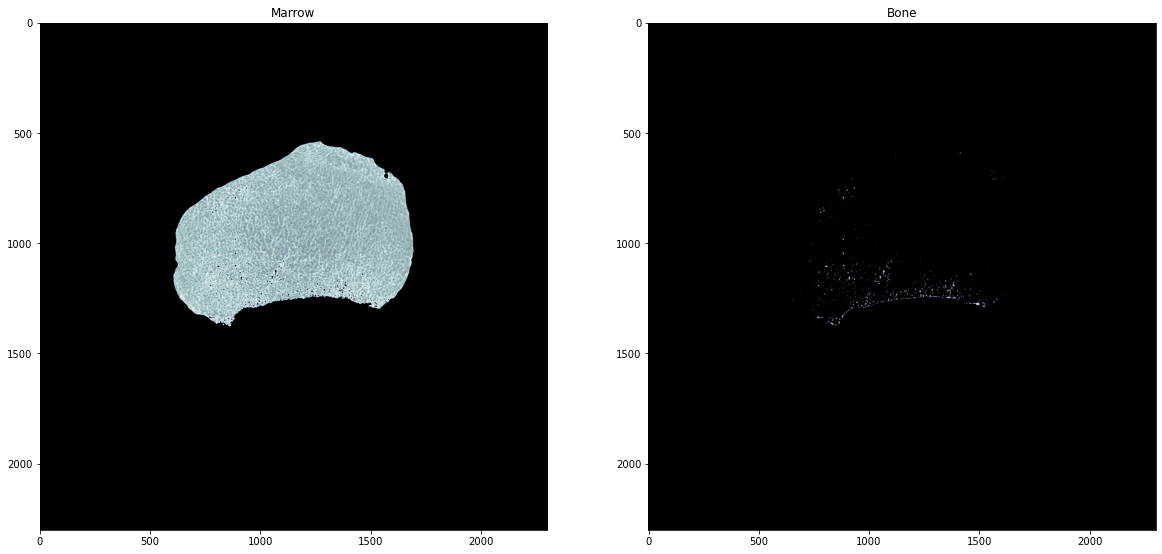

Revised Threshold=1199.7424051824648
	Mean marrow intensity=885.4259326805542 pixels
	Mean bone intensity=1372.729987729498 pixels




In [29]:
ITSA_th, ITSA_im = optimize_thresh(ROI_nb, th1, 'on')
ITSA_n = sitk.GetArrayFromImage(ITSA_im)

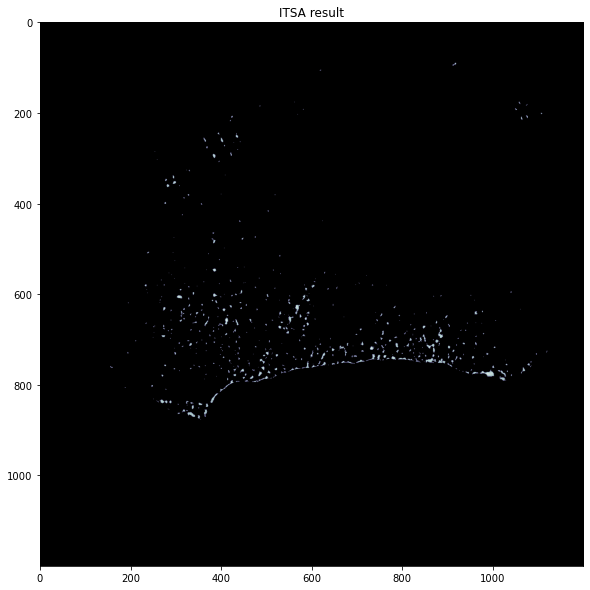

In [30]:
# ITSA result image
plt.figure(figsize=(15,10))
plt.imshow(ITSA_n[slice_index, 500:1700, 500:1700], cmap='bone')
plt.title('ITSA result')
plt.show()

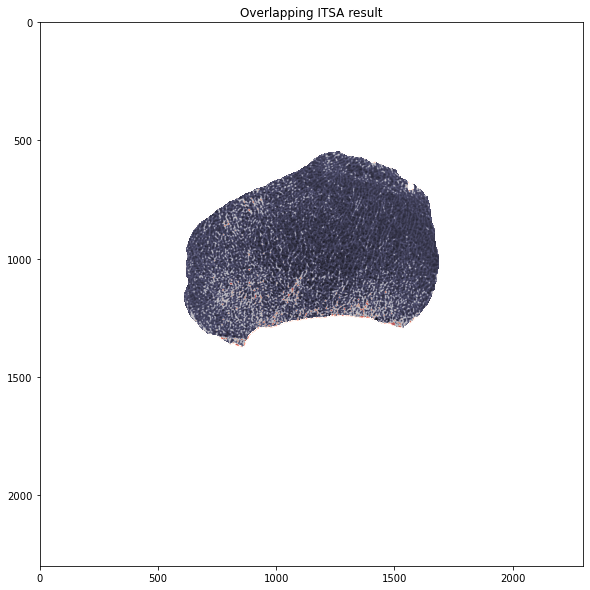

In [31]:
# Overlapping ITSA result to image
plt.figure(figsize=(15,10))
plt.imshow(ROI_nb[slice_index], cmap='bone')
plt.imshow(ITSA_n[slice_index], cmap='Reds', alpha=0.6*th_img[slice_index]) 
plt.title('Overlapping ITSA result')
plt.show()

#### Compare initial Otsu threshold to ITSA

In [32]:
print('Otsu threshold: ', th1)
print('ITSA threshold: ', ITSA_th)

Otsu threshold:  1009.5808914131064
ITSA threshold:  1199.7424051824648


Text(0.5, 1.0, 'ITSA bone result')

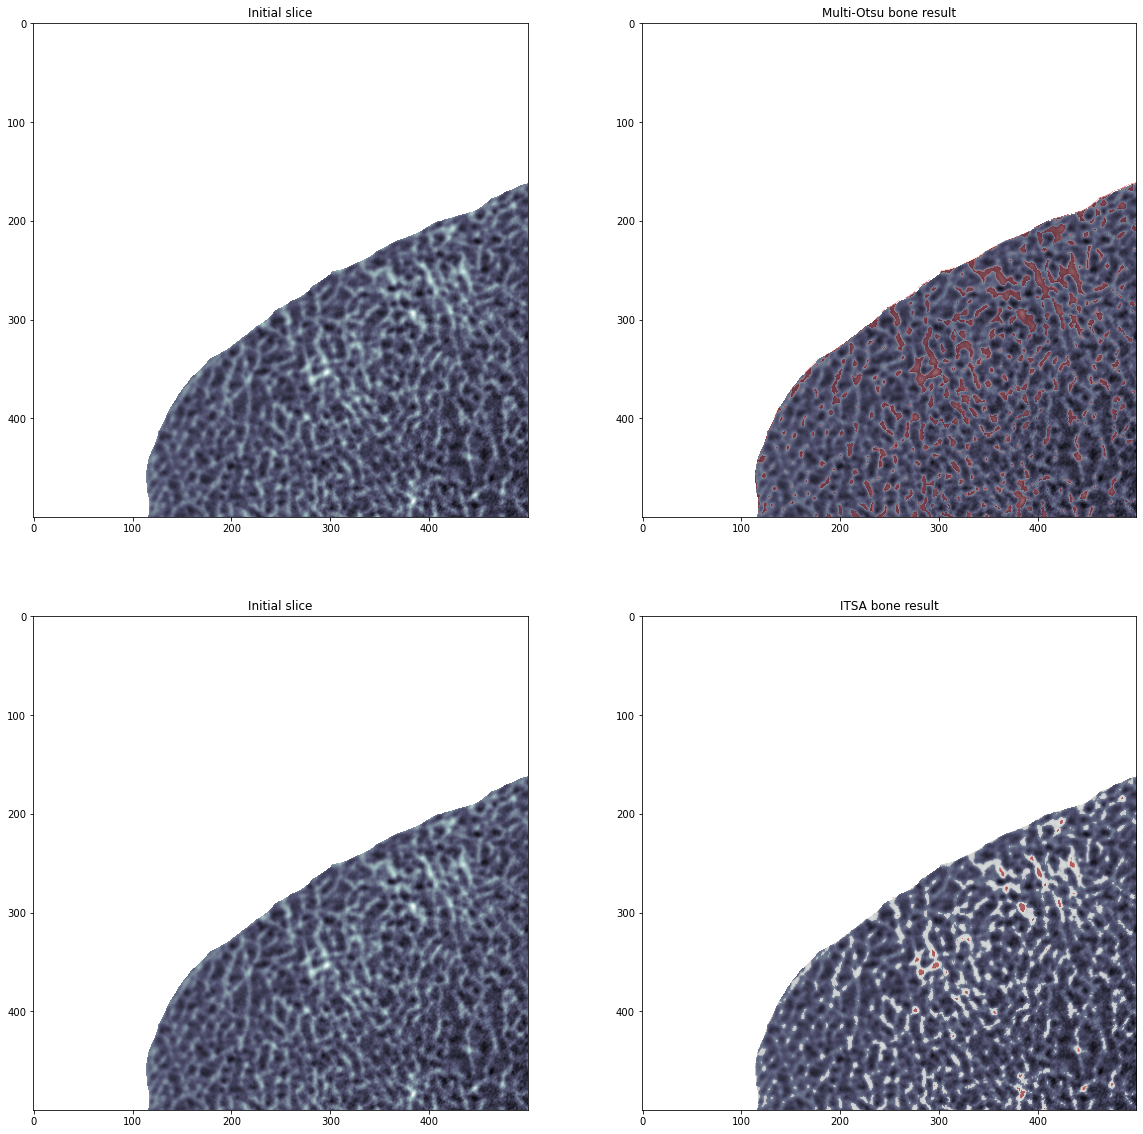

In [33]:
fig, axs = plt.subplots (2,2, figsize=(20,20))  
axs[0,0].imshow(ROI_nb[slice_index, 500:1000, 500:1000], cmap='bone')
axs[0,0].set_title('Initial slice')

axs[0,1].imshow(ROI_nb[slice_index, 500:1000, 500:1000], cmap='bone')
axs[0,1].imshow(th_img[slice_index, 500:1000, 500:1000], cmap='Reds', alpha=0.6*th_img[slice_index, 500:1000, 500:1000])
axs[0,1].set_title('Multi-Otsu bone result')

axs[1,0].imshow(ROI_nb[slice_index, 500:1000, 500:1000], cmap='bone')
axs[1,0].set_title('Initial slice')

axs[1,1].imshow(ROI_nb[slice_index, 500:1000, 500:1000], cmap='bone')
axs[1,1].imshow(ITSA_n[slice_index, 500:1000, 500:1000], cmap='Reds', alpha=0.6*th_img[slice_index, 500:1000, 500:1000])
axs[1,1].set_title('ITSA bone result')

## Calculations

In [34]:
# Calculate periosteal circumference
def get_peri_circ(image):
    peri_c = 0

    for l in range(len(image)):
        # Change slice into compatible format for findContours function
        peri_np8 = (image[l]*1).astype(np.uint8) 
        contours, hierarchy = cv2.findContours(peri_np8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        blank = np.zeros(peri_np8.shape, np.uint8) 

        # Find largest contour per slice
        areas = [cv2.contourArea(c) for c in contours] 
        max_index = np.argmax(areas)
        cnt = contours[max_index]

        # Plot contour
        #plt.imshow(cv2.drawContours(blank, cnt, -1, (255, 0, 0), 3),cmap='bone')
        #plt.title('Periosteal perimeter')
        #plt.show()

        # Calculate periosteal perimeter per slice and total
        peri_cl = cv2.arcLength(cnt,True)
        peri_c = peri_c + peri_cl
    return peri_c

In [35]:
trab_ROI = ITSA_n

In [36]:
### Total bone parameters *voxelsize (product of dimensions (image get size))
# Bone volume
### peri or trab>otsu (0, 1)
BV = np.sum(peri_ROI)

# Total volume
### peri mask
TV = np.sum(peri_np)

# Bone volume fraction
BVF = BV/TV

### Trabecular bone parameters
# Trabecular mass
Tb_N = np.sum(trab_ROI)

# Trabecular density
# Trabecular tissue mineral density (trabecular TMD)
###### mass of bone/volume of only bone

# Trabecular thickness
Tb_Th = (BV/TV)/Tb_N #200um

# Trabecular separation
Tb_Sp = (1-BV/TV)/Tb_N

## Cortical bone parameters
# Cortical thickness
####### sum of pixels / average circ
#### trab = 1/10 cortical values ish
peri_circ = get_peri_circ(peri_np)
Ct_Th = np.mean(cort_ROI)/peri_circ

### Derived equations

In [37]:
# Bone volume fraction
AB = BV # If BV/TV = AB/AT, then
AT = TV 

# Mean trabecular thickness
PB = (2*AB)/Tb_Th # If Tb.Th = 2 AB/PB, then

# Bone surface fraction
BS = TV*PB/AT # If BS/TV = PB/AT, then
BSF = PB/AT

### Summary table

In [38]:
print(tabulate([['Bone volume','BV', 'Sum of bone', BV],
                ['Total volume','TV', 'Sum of all', TV],
                ['Bone volume fraction', 'BV/TV', 'BV/TV', BVF],
                ['Trabecular mass', 'Tb.N', 'Sum of trabecular bone', Tb_N],
                ['Trabecular thickness', 'Tb.Th', 'Tb.Th = (BV/TV)/Tb.N', Tb_Th],
                ['Trabecular separation', 'Tb.Sp', 'Tb.Sp = (1 – BV/TV)/Tb.N', Tb_Sp],
                ['Cortical thickness', 'Ct.Th', 'Ct.Th = Mean cort. area/Peri. circum.', Ct_Th],
                ['--- DERIVED EQUATIONS', '', '', ''],
                ['Bone volume fraction', 'BV/TV', 'BV/TV = AB/AT', BVF], 
                ['Total bone area', 'AB', 'BV/TV = AB/AT', AB],
                ['Total mask area \n  with bone and marrow', 'AT', 'BV/TV = AB/AT'  , AT],
                ['Total perimeter \n  along bone contour'  , 'PB', 'Tb.Th = 2AB/PB', PB],
                ['Bone surface', 'BS', 'BS/TV = PB/AT', BS],
                ['Bone surface fraction', 'BS/TV', 'BS/TV = PB/AT', BSF]],
                headers=['Parameter', 'Abbreviation', 'Equation', 'Value']))

Parameter               Abbreviation    Equation                               Value
----------------------  --------------  -------------------------------------  ----------------------
Bone volume             BV              Sum of bone                            812833664.7412611
Total volume            TV              Sum of all                             4919741
Bone volume fraction    BV/TV           BV/TV                                  165.21879195292215
Trabecular mass         Tb.N            Sum of trabecular bone                 538302182.3642434
Trabecular thickness    Tb.Th           Tb.Th = (BV/TV)/Tb.N                   3.069257331026878e-07
Trabecular separation   Tb.Sp           Tb.Sp = (1 – BV/TV)/Tb.N               -3.050680404669122e-07
Cortical thickness      Ct.Th           Ct.Th = Mean cort. area/Peri. circum.  0.00024253112840668322
--- DERIVED EQUATIONS
Bone volume fraction    BV/TV           BV/TV = AB/AT                          165.21879195292215
Total bon

# Notes
SITK pixel types http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/03_Image_Details.html

SITK documentation https://readthedocs.org/projects/simpleitk/downloads/pdf/release/

SITK liver segmentation example https://notebook.community/jon-young/medicalimage/Liver%20Interactive

SITK Hamming filter https://simpleitk.org/SimpleITK-Notebooks/20_Expand_With_Interpolators.html

Laplace Hamming https://scikit-image.org/docs/stable/auto_examples/filters/plot_window.html, https://examples.itk.org/src/filtering/imagefeature/laplacianrecursivegaussianimagefilter/documentation, https://wsthub.medium.com/python-computer-vision-tutorials-image-fourier-transform-part-3-e65d10be4492, https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform

In [39]:
# If applying filter to more than one image:
# lap = sitk.LaplacianImageFilter()
# img_lap = lap.Execute(img_np), else in line